# Transfer Learning


Transfer learning takes advantage of knowledge gained from solving a problem in one domain, and transferring it to another domain.

![](images/transfer_learning_setup.png)

A common application of transfer learning is using the features learned by large convolutional neural networks as the knowledge we can transfer to another domain. Models like VGG16 have learned generalized features seen in the 1000 classes of ImageNet, and these features can be used for a more specialized task.

One of the biggest benefits and motivations of transfer learning is to take advantage of small datasets for domains and tasks with little data available.



## Definition

A domain $\mathcal{D}$ consists of a feature space $\mathcal{X}$ and marginal probability distribution $P(X)$ over the feature space, where $X = x_1, ..., x_n \in \mathcal{X}$.

Given a domain, $\mathcal{D} = \left\{\mathcal{X}, P(X)\right\}$, a task $\mathcal{T}$ consists of a label space $\mathcal{Y}$ and a conditional probability distribution $P(Y|X)$ learned from the training data.

Given a source domain $\mathcal{D}_S$, a corresponding source task $\mathcal{T}_S$, as well as a target domain $\mathcal{D}_T$ and a target task $\mathcal{T}_T$, the objective of transfer learning is to learn the target conditional probability distribution $P(Y_T|X_T)$ in $\mathcal{D_T}$ with information gained from $\mathcal{D}_S$ and $\mathcal{D}_T$ where $\mathcal{D}_S \neq \mathcal{D}_T$ or $\mathcal{T}_S \neq \mathcal{T}_T$.

## Scenarios

The most common scenarios involve the feature spaces being different, or either of the marginal or conditional probability distributions being different.

## Applications

- Simulations - training in a simulator, using knowledge learned in real environments
- Domain adaptation - easily accessible data is different than data in the wild

![](images/transfer_learning_bikes.png)


# Demo: Sharks xor Dolphin Classifier

Some code adapted from Francois Chollet:

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

http://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb

We will create a classifier to detect if a given image contains a shark xor a dolphin.

This classifier will be trained on features extracted from VGG16. We will then "fine tune" the last convolutional block of VGG, with our classifier on top using data augmentation.

Our training data consists of only 2000 images (compared to ImageNet's 13M images), which we will see can still give us an impressive accuracy.

### Big files

Data: https://drive.google.com/open?id=0B8UdlI1bRN65YW9QTW12VXFDVFk

Fully connected classifier weights: https://drive.google.com/open?id=0B8UdlI1bRN65ck9vNmRncU1XbGM

Extracted train features: https://drive.google.com/open?id=0B8UdlI1bRN65aklWbnNBWkdyb1k

Extracted validation features: https://drive.google.com/open?id=0B8UdlI1bRN65N1VpMnVpcnlHRDQ

## Data and preprocessing
- Our data is a collection of images of dolphins and sharks sourced from Flickr (https://github.com/8000net/flicker-search-dl)
- We will resize the images to 150x150 and scale all RGB values to 0-1.

Using TensorFlow backend.


Found 1000 images belonging to 2 classes.


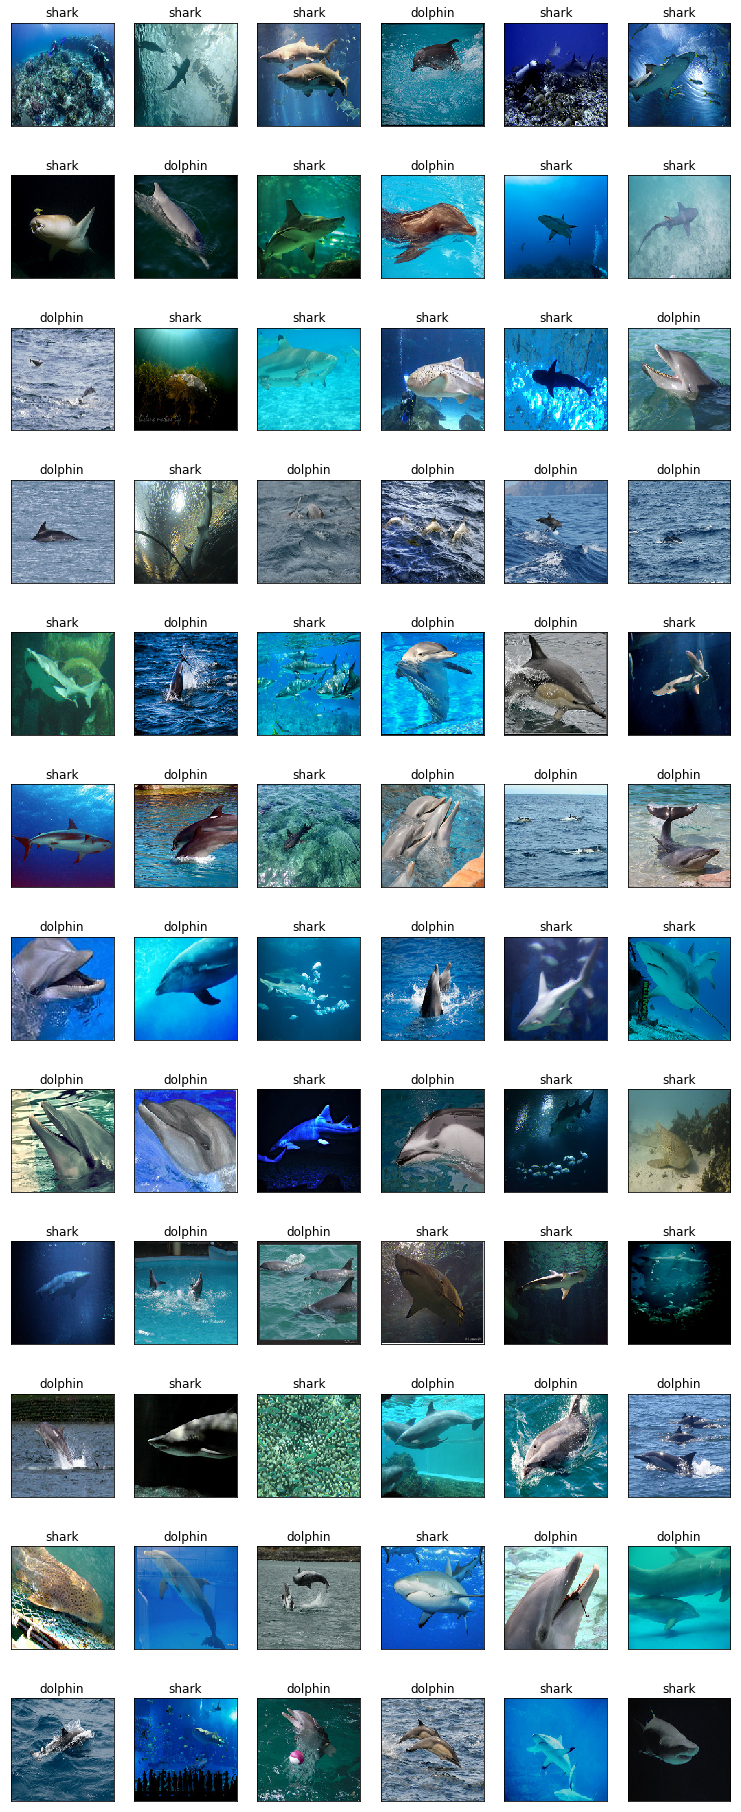

In [1]:
%matplotlib inline

import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# dimensions of our images.
img_width, img_height = 150, 150

test_dir = '../data/test'
test_datagen = ImageDataGenerator(rescale=1./255)
plot_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_width, img_height),
        batch_size=1,
        class_mode='binary')

num_images = 72
batch_size = 20
images = []
titles = []
i = 1
for inputs, labels in plot_generator:
    i += 1
    images.append(np.reshape(inputs, (img_width, img_height, 3)))
    # Some predictions for class 0 can have underflow error
    # so check if == 1
    titles.append('shark' if labels[0] == 1 else 'dolphin')
   
    if i > num_images:
        break
        
        
def plot_gallery(images, titles, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i])
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
plot_gallery(images, titles, n_row=12, n_col=6)

# Feature Extraction
- First we run all training and validation images through VGG16 with the classifier removed
  to extract the features and save them out
- We do this so that we can train the classifier with multiple epochs without re-extracting the features (takes ~3 min on Tesla P100 to extract the features of 2800 150x150 images)

In [2]:
%%time

from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input
from keras.applications import VGG16
from keras import optimizers
import pandas as pd


train_data_dir = '../data/train'
validation_data_dir = '../data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16


#
# Save bottleneck features from VGG
#

# build the VGG16 network, leaving off the top classifier layer
# so we just get the features as output
print('Building VGG16...')
input_tensor = Input(shape=(img_width, img_height, 3))
base_model = VGG16(weights='imagenet', include_top=False,
        input_tensor=input_tensor)

datagen = ImageDataGenerator(rescale=1/255)
generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None, # class mode set to None here, because images are loaded in order, 
                     # so we know the first 1000 are dolphins, next 1000 are sharks
    shuffle=False)

print('Saving bottleneck features (train)...')
bottleneck_features_train = base_model.predict_generator(
    generator, nb_train_samples // batch_size)
np.save('../features/bottleneck_features_train.npy', bottleneck_features_train)

generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

print('Saving bottleneck features (validation)...')
bottleneck_features_validation = base_model.predict_generator(
    generator, nb_validation_samples // batch_size)

np.save('../features/bottleneck_features_validation.npy',
        bottleneck_features_validation)


Building VGG16...
Found 2000 images belonging to 2 classes.
Saving bottleneck features (train)...
Found 800 images belonging to 2 classes.
Saving bottleneck features (validation)...
CPU times: user 13.3 s, sys: 8.46 s, total: 21.8 s
Wall time: 3min 21s


# Train a classifier layer with extracted features

- Now we can train our classifier with the extracted features
- The classifier is simply a fully connected layer with 256 hidden units

In [3]:
%%time

epochs = 30
batch_size = 20
top_model_weights_path = '../models/dolphin_sharks_fc.h5'


# Load extracted features
train_data = np.load('../features/dolphin_sharks_feats_train.npy')
train_labels = np.array(
    [0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

validation_data = np.load('../features/dolphin_sharks_feats_val.npy')
validation_labels = np.array(
    [0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))


# Build model
print('Building top model...')
top_model = Sequential()
top_model.add(Flatten(input_shape=train_data.shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))
top_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', metrics=['accuracy'])

# Train model
print('Training top model...')
history = top_model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              verbose=1)
top_model.save_weights(top_model_weights_path)

Building top model...
Training top model...
Train on 2000 samples, validate on 800 samples
Epoch 1/30
2000/2000 [==============================] - 0s - loss: 0.5075 - acc: 0.8585 - val_loss: 0.2180 - val_acc: 0.9138
Epoch 2/30
2000/2000 [==============================] - 0s - loss: 0.2306 - acc: 0.9210 - val_loss: 0.2423 - val_acc: 0.9125
Epoch 3/30
2000/2000 [==============================] - 0s - loss: 0.1635 - acc: 0.9380 - val_loss: 0.4049 - val_acc: 0.8750
Epoch 4/30
2000/2000 [==============================] - 0s - loss: 0.1544 - acc: 0.9485 - val_loss: 0.2054 - val_acc: 0.9350
Epoch 5/30
2000/2000 [==============================] - 0s - loss: 0.1192 - acc: 0.9580 - val_loss: 0.2041 - val_acc: 0.9400
Epoch 6/30
2000/2000 [==============================] - 0s - loss: 0.1104 - acc: 0.9620 - val_loss: 0.1853 - val_acc: 0.9425
Epoch 7/30
2000/2000 [==============================] - 0s - loss: 0.1079 - acc: 0.9595 - val_loss: 0.2193 - val_acc: 0.9475
Epoch 8/30
2000/2000 [============

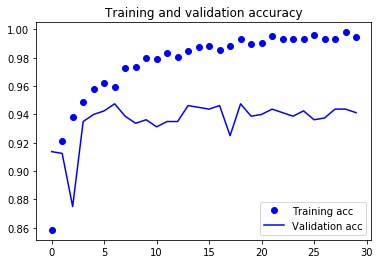

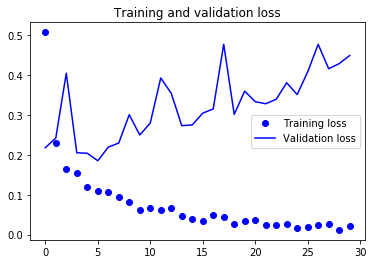

In [4]:
# Plot training and validation accuracy

def plot_training_validation_acc(history, smooth=False, smooth_factor=0.8):
    def smooth_curve(points, factor=0.8):
        smoothed_points = []
        for point in points:
            if smoothed_points:
                previous = smoothed_points[-1]
                smoothed_points.append(previous * factor + point * (1 - factor))
            else:
                smoothed_points.append(point)
        return smoothed_points

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    if smooth:
        acc = smooth_curve(acc)
        val_acc = smooth_curve(val_acc)
        loss = smooth_curve(loss)
        val_loss = smooth_curve(val_loss)

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
    
plot_training_validation_acc(history)

We get pretty good validation accuracy, especially with such a small dataset, but there seems to be some overfitting.

# Fine tuning and Data Augmentation

- To improve our classifier, we can place it on top of VGG, "unfreeze" the last convolutional block of VGG, then continue training with augmented samples from our dataset.

- This will "fine tune" the last block in VGG, tweaking it to our domain, as well as continuing to train the classifier.

- It is necessary to pre-train the classifier. If we were to place randomly initialized layers on top, large gradient updates would wreck the learned weights in the block we are fine tuning.


In [13]:
%%time

epochs = 20
batch_size = 16

#
# Fine tune top convulational block
#

print('Building combined model...')
# note that it is necessary to start with a fully-trained
# classifier, in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
model = Model(inputs=base_model.input,
              outputs=top_model(base_model.output))

# Freeze all blocks up to block5 (the block we are fine tuning)
set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    
    
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')


# fine-tune the model
print('Training combined model...')
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    verbose=1)

Building combined model...
Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Training combined model...
Epoch 1/20
125/125 [==============================] - 15s - loss: 0.0873 - acc: 0.9710 - val_loss: 0.1334 - val_acc: 0.9587
Epoch 2/20
125/125 [==============================] - 13s - loss: 0.0925 - acc: 0.9665 - val_loss: 0.1252 - val_acc: 0.9600
Epoch 3/20
125/125 [==============================] - 14s - loss: 0.0904 - acc: 0.9675 - val_loss: 0.1584 - val_acc: 0.9513
Epoch 4/20
125/125 [==============================] - 14s - loss: 0.0582 - acc: 0.9775 - val_loss: 0.1525 - val_acc: 0.9613
Epoch 5/20
125/125 [==============================] - 14s - loss: 0.0648 - acc: 0.9755 - val_loss: 0.1403 - val_acc: 0.9525
Epoch 6/20
125/125 [==============================] - 14s - loss: 0.0550 - acc: 0.9825 - val_loss: 0.1005 - val_acc: 0.9738
Epoch 7/20
125/125 [==============================] - 14s - loss: 0.0661 - acc: 0.9780 - val_loss: 0.1137 - val_acc: 0.

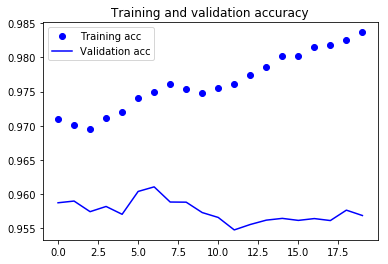

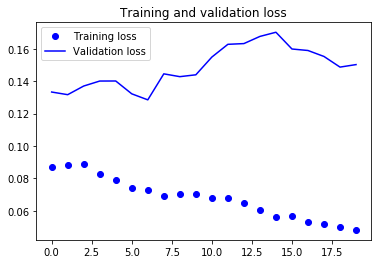

In [14]:
plot_training_validation_acc(history, smooth=True)

In [15]:
test_dir = '../data/test'
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_width, img_height),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.968999992609


We get an increase in validation accuracy, and there seems to be less overfitting now.

We can plot selected images from the test set and see what the classifier predicted (true label is in parentheses).

Found 1000 images belonging to 2 classes.


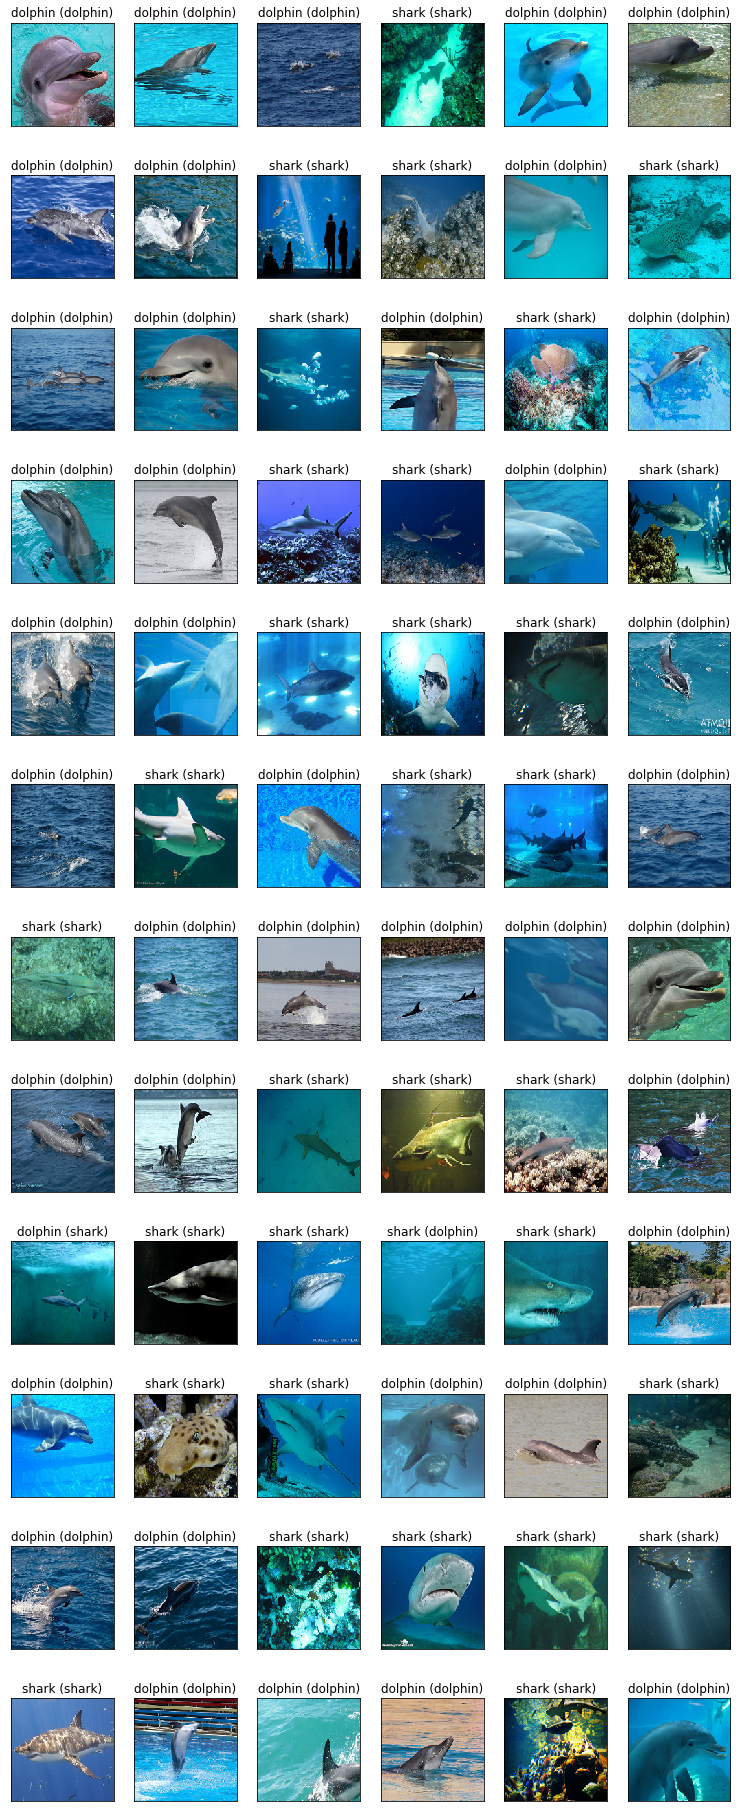

In [16]:
plot_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_width, img_height),
        batch_size=1,
        class_mode='binary')

num_images = 72
batch_size = 20
images = []
titles = []
predictions = []
i = 1
for inputs, labels in plot_generator:
    i += 1
    images.append(np.reshape(inputs, (img_width, img_height, 3)))
    # Some predictions for class 0 can have underflow error
    # so check if == 1
    titles.append('shark' if labels[0] > .5 else 'dolphin')
    y_hat = model.predict(inputs)
    predictions.append('shark' if y_hat > .5 else 'dolphin')
   
    if i > num_images:
        break
        
for i in range(num_images):
    predictions[i] += ' (%s)' % titles[i]
        
plot_gallery(images, predictions, n_row=12, n_col=6)

# Conclusion

By fine tuning the last convolutional block, we were able to achieve a slight increase in accuracy. If we were to use data augmentation from the beginning while training our classifier intially by placing the classifier directly on top of VGG instead of saving out the features, the training time would take longer, but we could get a slight increase in accuracy.